## Porto Seguro's Safe Driver Prediction
Predict if a driver will file an insurance claim next year.

In [16]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, random as rd
import time
import xgboost as xgb, catboost, lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, auc, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from IPython.display import display
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data description

In this competition, you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

## Normalized Gini Coefficient
https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703

In [18]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)
 
def test_gini():
    def fequ(a,b):
        return abs(a - b) < 1e-6
    def T(a, p, g, n):
        assert( fequ(gini(a,p), g) )
        assert( fequ(gini_normalized(a,p), n) )
    T([1, 2, 3], [10, 20, 30], 0.111111, 1)
    T([1, 2, 3], [30, 20, 10], -0.111111, -1)
    T([1, 2, 3], [0, 0, 0], -0.111111, -1)
    T([3, 2, 1], [0, 0, 0], 0.111111, 1)
    T([1, 2, 4, 3], [0, 0, 0, 0], -0.1, -0.8)
    T([2, 1, 4, 3], [0, 0, 2, 1], 0.125, 1)
    T([0, 20, 40, 0, 10], [40, 40, 10, 5, 5], 0, 0)
    T([40, 0, 20, 0, 10], [1000000, 40, 40, 5, 5], 0.171428, 0.6)
    T([40, 20, 10, 0, 0], [40, 20, 10, 0, 0], 0.285714, 1)
    T([1, 1, 0, 1], [0.86, 0.26, 0.52, 0.32], -0.041666, -0.333333)

#--------------
test_gini()

## ML utilities

In [63]:
def balance_num_samples_in_classes(x_array, y_array, flag_balance_classes=True, seed=10, verbose=False):
    np.random.seed(seed)

    if verbose:
        print('# users with label 0:', len(y_array[y_array == 0]))
        print('# users with label 1:', len(y_array[y_array == 1]))

    if flag_balance_classes:
        ratio = (1.0 * sum(y_array))/(len(y_array) - sum(y_array))
        if verbose:
            print('1/0 ratio:', ratio)
        IDX = []
        for i in range(len(y_array)):
            if y_array[i] == 1:
                IDX.append(i)
            else:
                if random.random() < ratio:
                    IDX.append(i)

        IDX = np.array(IDX)
        new_x_array = x_array[IDX]
        new_y_array = y_array[IDX]

        if verbose:
            print('After balancing:')
            print('# users with label 0 in training set:', len(new_y_array[new_y_array == 0]))
            print('# users with label 1 in training set:', len(new_y_array[new_y_array == 1]))
        return (new_x_array, new_y_array)
    else:
        if verbose:
            print('classes are not balanced!')
        return (x_array, y_array)

######################################################################################################
def compute_avg_std_of_samples(x_train_array):
    avgs = np.mean(x_train_array, axis=0)
    stds = np.std(x_train_array, axis=0)
    zero_stds = (stds == 0)
    stds[zero_stds] = 1.0
    return (avgs, stds)

def scale_features(x_array, avgs, stds, verbose=False):
    new_x_array = (x_array - avgs)/stds
    if verbose:
        print('... feature scaling: -mean/std')
    return new_x_array

def standardize_features(x_array, flag_scale_values, avgs, stds, verbose=False):
    if flag_scale_values:
        assert((avgs.all() != None) and (stds.all() != None))
        
    new_x_array = None
    if flag_scale_values:
        new_x_array = scale_features(x_array, avgs, stds, verbose)
    else:
        if verbose:
            print('... feature values are not re-scaled!')
    return new_x_array

## Prepare training & validation data

In [64]:
df_train = pd.read_csv('../data/train.csv')
print('# samples in train.csv:', len(df_train))

X = np.array(df_train.drop(['target', 'id'], axis=1))
Y = np.array(df_train['target'])
print('X.shape, Y.shape:', X.shape, Y.shape)

# print a sample
print(X[0])
print(Y[0:10])

# samples in train.csv: 595212
X.shape, Y.shape: (595212, 57) (595212,)
[  2.           2.           5.           1.           0.           0.           1.
   0.           0.           0.           0.           0.           0.           0.
  11.           0.           1.           0.           0.7          0.2
   0.71807033  10.           1.          -1.           0.           1.           4.
   1.           0.           0.           1.          12.           2.
   0.4          0.88367892   0.37080992   3.60555128   0.6          0.5
   0.2          3.           1.          10.           1.          10.           1.
   5.           9.           1.           5.           8.           0.           1.
   1.           0.           0.           1.        ]
[0 0 0 0 0 0 0 0 0 1]


In [65]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print('balance the numbers of samples in classes for training data:\n')
print('original:\n x_train.shape: {}\n y_train.shape: {}\n x_val.shape: {}\n y_val.shape: {}\n'
      .format(x_train.shape, y_train.shape, x_val.shape, y_val.shape))

balanced_x_train, balanced_y_train = balance_num_samples_in_classes(x_train, y_train, True, seed=10)

print('after balancing classes:\n x_train.shape: {}\n y_train.shape: {}\n x_val.shape: {}\n y_val.shape: {}\n'
      .format(balanced_x_train.shape, balanced_y_train.shape, x_val.shape, y_val.shape))

print('scale feature values (e.g., to have standard normal distribution):')
avg_sample, std_sample = compute_avg_std_of_samples(balanced_x_train)
scaled_balanced_x_train = standardize_features(balanced_x_train, True, avg_sample, std_sample, True)
scaled_x_val = standardize_features(x_val, True, avg_sample, std_sample, True)

balance the numbers of samples in classes for training data:

original:
 x_train.shape: (476169, 57)
 y_train.shape: (476169,)
 x_val.shape: (119043, 57)
 y_val.shape: (119043,)

after balancing classes:
 x_train.shape: (34892, 57)
 y_train.shape: (34892,)
 x_val.shape: (119043, 57)
 y_val.shape: (119043,)

scale feature values (e.g., to have standard normal distribution):
... feature scaling: -mean/std
... feature scaling: -mean/std


## Fit and tune model

In [67]:
print(datetime.datetime.now().strftime("%Y%m%d %H:%M"))
start_time = time.time()

MODELS = [xgb.XGBClassifier()]
best_model = None
best_gini = 0

for model in MODELS:
    model.fit(scaled_balanced_x_train, balanced_y_train)
    
    print('\nModel type: {}\n'.format(type(model)))
    
    y_train_pred = model.predict_proba(scaled_balanced_x_train)[:,1]
    print('train auc: {:.3f}'.format(roc_auc_score(balanced_y_train, y_train_pred)))
    print('confusion matrix on train:\n{}')
    print(confusion_matrix(balanced_y_train, model.predict(scaled_balanced_x_train)))

    y_val_pred = model.predict_proba(scaled_x_val)[:,1]
    print('val auc: {:.3f}'.format(roc_auc_score(y_val, y_val_pred)))
    print('confusion matrix on val:\n{}')
    print(confusion_matrix(y_val, model.predict(scaled_x_val)))
    
    n_gini = gini_normalized(y_val, y_val_pred)
    print('normalized gini: {:.3f}\n'.format(n_gini))
    if n_gini > best_gini:
        best_gini = n_gini
        best_model = model
        
print('Best model:', type(best_model))
print('DONE. {}s'.format(int(time.time() - start_time)))

20171102 17:08

Model type: <class 'xgboost.sklearn.XGBClassifier'>

train auc: 0.656
confusion matrix on train:
{}
[[11412  6171]
 [ 7356  9953]]
val auc: 0.636
confusion matrix on val:
{}
[[72681 41977]
 [ 1919  2466]]
normalized gini: 0.272

Best model: <class 'xgboost.sklearn.XGBClassifier'>
DONE. 7s


## Use best model to train again with all possible training data

In [72]:
start_time = time.time()
print(datetime.datetime.now().strftime("%Y%m%d %H:%M"))

print('balance the numbers of samples in classes:\n')
print('original:\n X.shape: {}\n Y.shape: {}\n'.format(X.shape, Y.shape))
balanced_X, balanced_Y = balance_num_samples_in_classes(X, Y, flag_balance_classes=True, seed=10)
print('after balancing classes:\n X.shape: {}\n Y.shape: {}\n'.format(balanced_X.shape, balanced_Y.shape))

print('scale feature values')
scaled_balanced_X = standardize_features(balanced_X, True, avg_sample, std_sample, True)

print('build model:')
best_model.fit(scaled_balanced_X, balanced_Y)

print('... quick check on validation data:')
y_val_pred = best_model.predict_proba(scaled_x_val)[:,1]
#
print('..... val auc: {:.3f}'.format(roc_auc_score(y_val, y_val_pred)))
print('..... confusion matrix on val:')
print(confusion_matrix(y_val, model.predict(scaled_x_val)))
#
n_gini = gini_normalized(y_val, y_val_pred)
print('..... normalized gini: {:.3f}\n'.format(n_gini))

print('DONE. {}s'.format(int(time.time() - start_time)))

20171102 17:18
balance the numbers of samples in classes:

original:
 X.shape: (595212, 57)
 Y.shape: (595212,)

after balancing classes:
 X.shape: (43510, 57)
 Y.shape: (43510,)

scale feature values
... feature scaling: -mean/std
build model:
... quick check on validation data:
..... val auc: 0.647
..... confusion matrix on val:
[[72681 41977]
 [ 1919  2466]]
..... normalized gini: 0.294

DONE. 11s


## Predict the actual test data

In [73]:
print(datetime.datetime.now().strftime("%Y%m%d %H:%M"))

# load data
df_test = pd.read_csv('../data/test.csv')
print('# test samples:', len(df_test))

x_test = np.array(df_test.drop('id', axis=1))
y_test = df_test['id']

# transform features in the same way we did for training data
print('x_test.shape, y_test.shape:', x_test.shape, y_test.shape)
scaled_x_test = standardize_features(x_test, True, avg_sample, std_sample, True)

# make & save predictions
predictions = best_model.predict_proba(scaled_x_test)[:,1]

submission = pd.DataFrame({'id': y_test, 'target': predictions})
submission.to_csv('submission.csv', index=False)
print('len(submission):', len(submission))
submission.head()

20171102 17:20
# test samples: 892816
x_test.shape, y_test.shape: (892816, 57) (892816,)
... feature scaling: -mean/std
len(submission): 892816


,id,target
0,0,0.410187
1,1,0.457469
2,2,0.451550
3,3,0.304179
4,4,0.517211


Text(0,0.5,'number of insurance policy holder')

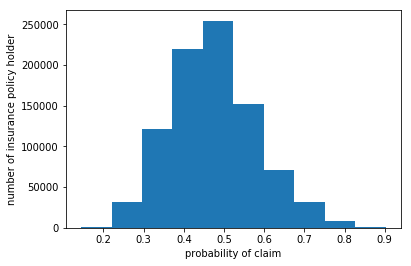

In [74]:
plt.hist(predictions)
plt.xlabel('probability of claim')
plt.ylabel('number of insurance policy holder')

## To be deleted